# Insurance Pricing Model Exploration

This notebook explores the insurance pricing model, including data generation, feature engineering, model training, and evaluation.

In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Add project root to path
sys.path.append('..')

# Import project modules
from src.data.generator import InsuranceDataGenerator
from src.ml.model import InsurancePricingModel, PricingService
from src.ml.features import FeatureProcessor
from src.ml.models import (
    Driver, DrivingHistory, Gender, IncidentSeverity, IncidentType,
    Location, MaritalStatus, Policy, PricingFactors, Vehicle, VehicleUse
)

## Data Generation

First, let's generate some synthetic data for training and testing the model.

In [2]:
# Create data generator
data_generator = InsuranceDataGenerator(seed=42)

# Generate policies and premiums
num_policies = 1000
policies, premiums = data_generator.generate_dataset(num_policies)

print(f"Generated {len(policies)} policies with premiums")

Generated 1000 policies with premiums


Let's examine a sample policy to understand the data structure.

In [3]:
# Examine a sample policy
sample_policy = policies[0]

print(f"Policy ID: {sample_policy.policy_id}")
print(f"Effective Date: {sample_policy.effective_date}")
print(f"Expiration Date: {sample_policy.expiration_date}")
print(f"Number of Drivers: {len(sample_policy.drivers)}")
print(f"Number of Vehicles: {len(sample_policy.vehicles)}")
print(f"Number of Locations: {len(sample_policy.locations)}")
print(f"Number of Driving History Incidents: {len(sample_policy.driving_history)}")

Policy ID: 56b8d353-fd14-4f5f-b811-727a528992a3
Effective Date: 2024-12-02
Expiration Date: 2025-12-02
Number of Drivers: 3
Number of Vehicles: 1
Number of Locations: 1
Number of Driving History Incidents: 0


In [4]:
# Examine a sample driver
sample_driver = sample_policy.drivers[0]

print(f"Driver: {sample_driver.first_name} {sample_driver.last_name}")
print(f"Date of Birth: {sample_driver.date_of_birth}")
print(f"Age: {sample_driver.age}")
print(f"Gender: {sample_driver.gender}")
print(f"Marital Status: {sample_driver.marital_status}")
print(f"Occupation: {sample_driver.occupation}")
print(f"License Number: {sample_driver.license_number}")
print(f"License Issue Date: {sample_driver.license_issue_date}")
print(f"Driving Experience: {sample_driver.driving_experience} years")

Driver: Angel Hill
Date of Birth: 1958-05-06
Age: 66
Gender: Gender.FEMALE
Marital Status: MaritalStatus.MARRIED
Occupation: Electrician
License Number: C819600
License Issue Date: 2011-11-10
Driving Experience: 13 years


In [5]:
# Examine a sample vehicle
sample_vehicle = sample_policy.vehicles[0]

print(f"Vehicle: {sample_vehicle.year} {sample_vehicle.make} {sample_vehicle.model}")
print(f"VIN: {sample_vehicle.vin}")
print(f"Value: ${sample_vehicle.value:.2f}")
print(f"Primary Use: {sample_vehicle.primary_use}")
print(f"Annual Mileage: {sample_vehicle.annual_mileage}")
print(f"Anti-Theft Device: {sample_vehicle.anti_theft_device}")
print(f"Vehicle Age: {sample_vehicle.vehicle_age} years")

Vehicle: 2016 Toyota Camry
VIN: 1MMWJBRUDNCUKXW1
Value: $15469.74
Primary Use: VehicleUse.BUSINESS
Annual Mileage: 5869
Anti-Theft Device: False
Vehicle Age: 9 years


Let's look at the distribution of premiums.

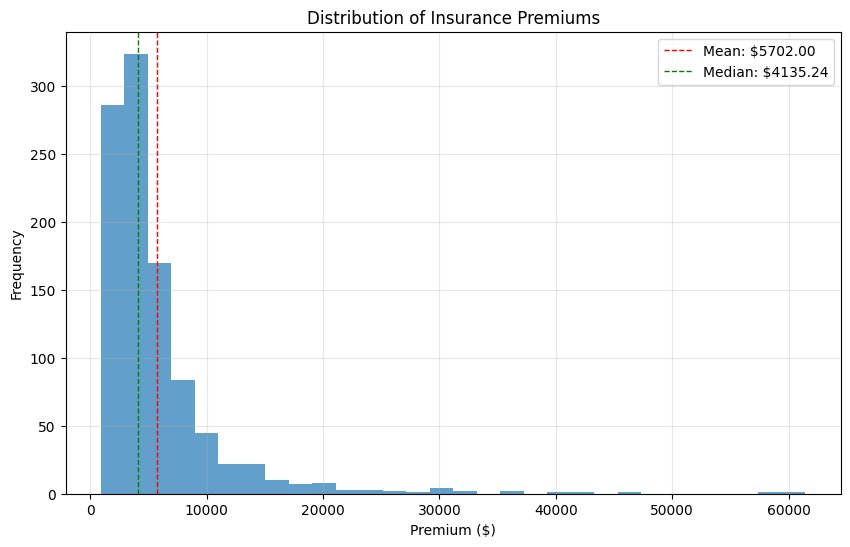

Premium Statistics:
Mean: $5702.00
Median: $4135.24
Min: $911.20
Max: $61448.68
Standard Deviation: $5568.60


In [6]:
# Plot premium distribution
plt.figure(figsize=(10, 6))
plt.hist(premiums, bins=30, alpha=0.7)
plt.axvline(np.mean(premiums), color='red', linestyle='dashed', linewidth=1, label=f'Mean: ${np.mean(premiums):.2f}')
plt.axvline(np.median(premiums), color='green', linestyle='dashed', linewidth=1, label=f'Median: ${np.median(premiums):.2f}')
plt.xlabel('Premium ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Insurance Premiums')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print premium statistics
print(f"Premium Statistics:")
print(f"Mean: ${np.mean(premiums):.2f}")
print(f"Median: ${np.median(premiums):.2f}")
print(f"Min: ${np.min(premiums):.2f}")
print(f"Max: ${np.max(premiums):.2f}")
print(f"Standard Deviation: ${np.std(premiums):.2f}")

## Feature Engineering

Now let's explore the feature engineering process. The `FeatureProcessor` class transforms the raw policy data into features that can be used by the machine learning model.

In [7]:
# Create feature processor
feature_processor = FeatureProcessor()

# Fit and transform the data
X = feature_processor.fit_transform(policies)

# Get feature names
feature_names = feature_processor.feature_names

print(f"Number of features: {len(feature_names)}")
print(f"Feature matrix shape: {X.shape}")

Number of features: 272
Feature matrix shape: (1000, 272)


In [8]:
# Display the first 20 feature names
print("First 20 features:")
for i, feature in enumerate(feature_names[:20]):
    print(f"{i+1}. {feature}")

First 20 features:
1. policy_duration_days
2. num_drivers
3. num_vehicles
4. num_locations
5. vehicle_per_driver_ratio
6. driver_driver_age_mean
7. driver_driver_age_max
8. driver_driver_age_min
9. driver_driver_experience_mean
10. driver_driver_experience_max
11. driver_driver_experience_min
12. driver_age_band_18-24_mean
13. driver_age_band_18-24_max
14. driver_age_band_18-24_min
15. driver_age_band_25-34_mean
16. driver_age_band_25-34_max
17. driver_age_band_25-34_min
18. driver_age_band_35-44_mean
19. driver_age_band_35-44_max
20. driver_age_band_35-44_min


## Model Training

Now let's train the insurance pricing model using the generated data.

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, premiums, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 800
Testing set size: 200


In [10]:
# Train a decision tree model
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
dt_pred = dt_model.predict(X_test)

# Calculate metrics
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

print(f"Decision Tree Metrics:")
print(f"MSE: {dt_mse:.2f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"MAE: {dt_mae:.2f}")
print(f"R²: {dt_r2:.4f}")

Decision Tree Metrics:
MSE: 28912094.28
RMSE: 5377.00
MAE: 2524.99
R²: -0.3046


In [11]:
# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Calculate metrics
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest Metrics:")
print(f"MSE: {rf_mse:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R²: {rf_r2:.4f}")

Random Forest Metrics:
MSE: 7903534.00
RMSE: 2811.32
MAE: 1605.04
R²: 0.6434


Let's compare the predictions of both models.

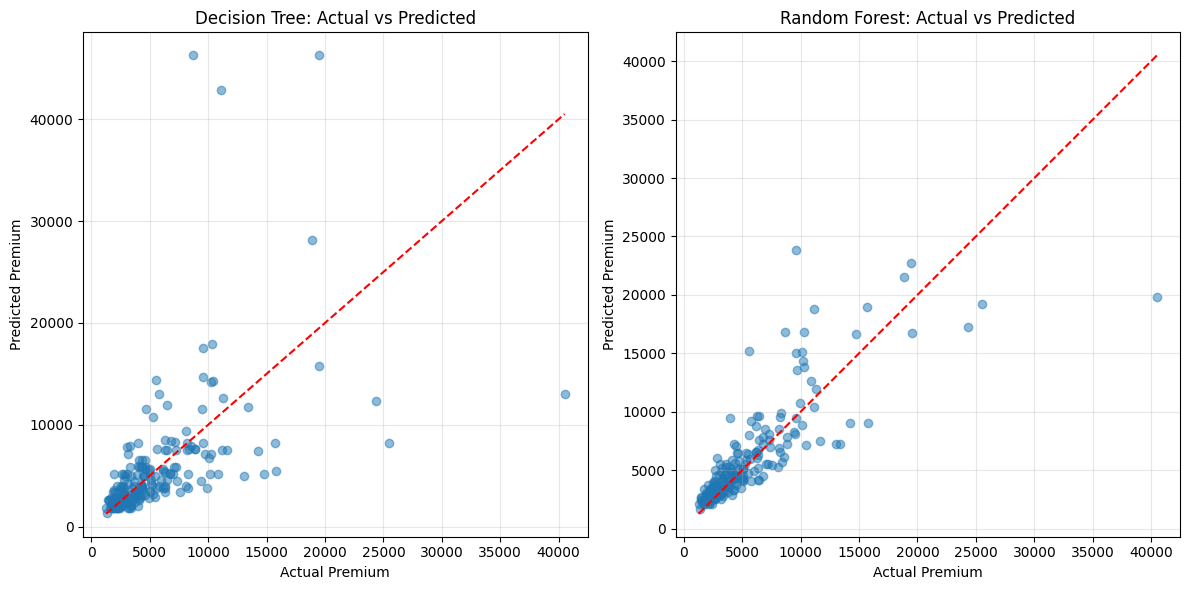

In [12]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, dt_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title('Decision Tree: Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance

Let's examine the feature importance to understand which factors have the most impact on the premium.

In [13]:
# Get feature importances
dt_importances = dt_model.feature_importances_
rf_importances = rf_model.feature_importances_

# Create DataFrames for feature importances
dt_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
}).sort_values('Importance', ascending=False)

rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

# Display top 20 features for each model
print("Top 20 Features (Decision Tree):")
display(dt_importance_df.head(20))

print("\nTop 20 Features (Random Forest):")
display(rf_importance_df.head(20))

Top 20 Features (Decision Tree):


,Feature,Importance
98,incident_severity_score,0.273986
271,insurance_score,0.115829
7,driver_driver_age_min,0.111815
2,num_vehicles,0.090602
157,location_state_ID_max,0.075653
58,vehicle_vehicle_value_min,0.050324
84,vehicle_use_business_max,0.033028
9,driver_driver_experience_max,0.025436
61,vehicle_annual_mileage_min,0.025349
47,driver_marital_status_widowed_mean,0.023989



Top 20 Features (Random Forest):


,Feature,Importance
98,incident_severity_score,0.296488
7,driver_driver_age_min,0.088678
2,num_vehicles,0.060972
271,insurance_score,0.049077
8,driver_driver_experience_mean,0.043828
10,driver_driver_experience_min,0.038304
57,vehicle_vehicle_value_max,0.020074
11,driver_age_band_18-24_mean,0.019712
50,driver_occupation_risk_mean,0.019704
58,vehicle_vehicle_value_min,0.018056


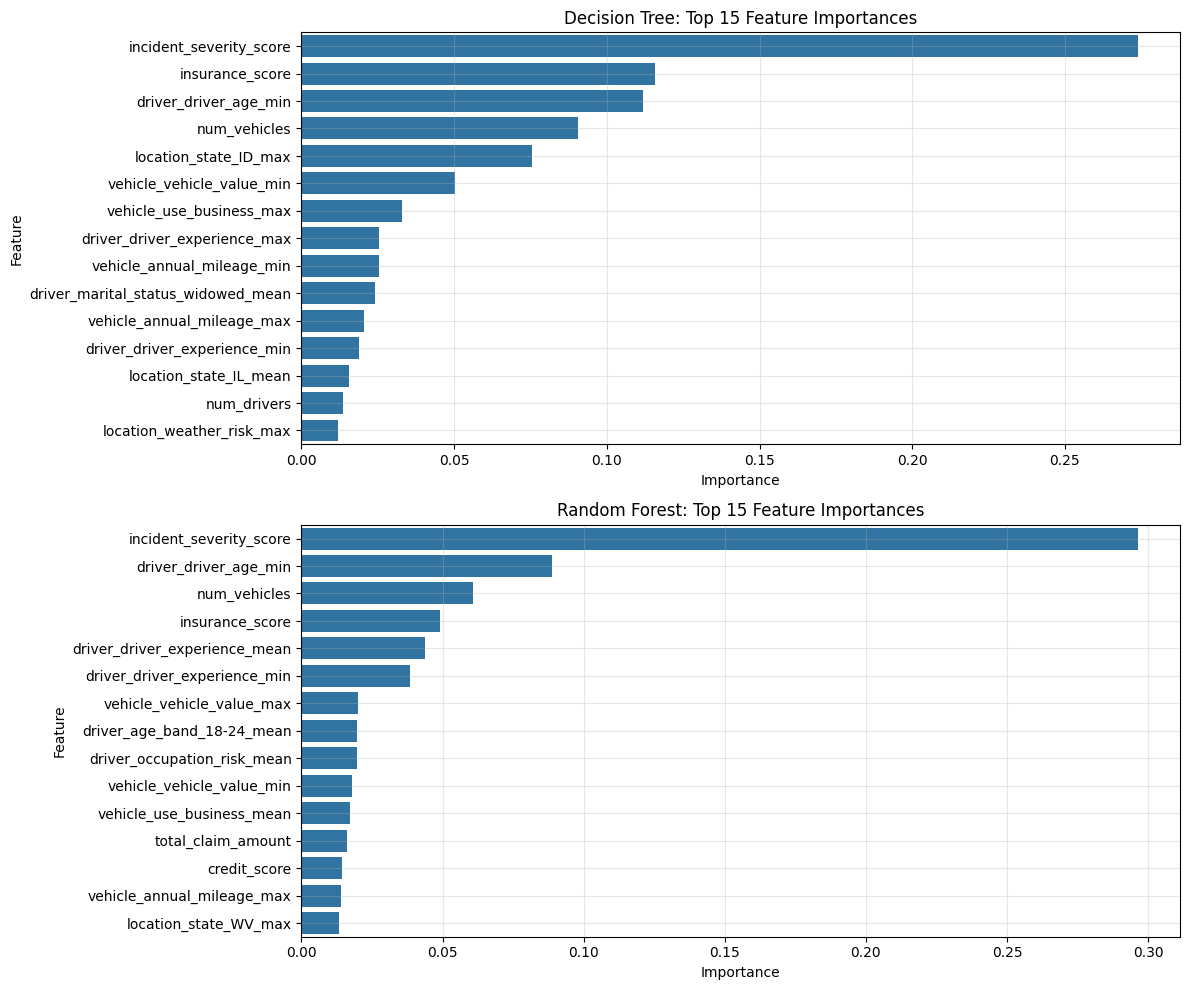

In [14]:
# Plot feature importances
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=dt_importance_df.head(15))
plt.title('Decision Tree: Top 15 Feature Importances')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(15))
plt.title('Random Forest: Top 15 Feature Importances')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Using the InsurancePricingModel Class

Now let's use the `InsurancePricingModel` class to train and evaluate the model.

In [15]:
# Create and train the model
model = InsurancePricingModel(model_type="decision_tree", model_params={"max_depth": 10})
metrics = model.train(policies, premiums, test_size=0.2, random_state=42)

print(f"Model Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Model Metrics:
mse: 28912094.2790
rmse: 5376.9968
mae: 2524.9924
r2: -0.3046


In [16]:
# Get feature importances
importances = model.feature_importances

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values('Importance', ascending=False)

# Display top 20 features
print("Top 20 Features:")
display(importance_df.head(20))

Top 20 Features:


,Feature,Importance
98,incident_severity_score,0.273986
271,insurance_score,0.115829
7,driver_driver_age_min,0.111815
2,num_vehicles,0.090602
157,location_state_ID_max,0.075653
58,vehicle_vehicle_value_min,0.050324
84,vehicle_use_business_max,0.033028
9,driver_driver_experience_max,0.025436
61,vehicle_annual_mileage_min,0.025349
47,driver_marital_status_widowed_mean,0.023989


## Pricing Service

Now let's use the `PricingService` class to calculate premiums for policies.

In [17]:
# Create pricing service
service = PricingService(model=model, base_premium=1000.0)

# Generate a new policy
new_policy = data_generator.generate_policy()

# Calculate premium
premium, factors = service.calculate_premium(new_policy)

print(f"Premium: ${premium:.2f}")
print(f"Factors:")
for factor, value in factors.items():
    print(f"{factor}: {value:.4f}")

Premium: $2666.01
Factors:
driver_factor: 0.2500
vehicle_factor: 0.2500
history_factor: 0.2500
location_factor: 0.2500
credit_factor: 1.0000
insurance_factor: 1.2000
territory_factor: 1.2356


Let's calculate premiums for multiple policies and analyze the results.

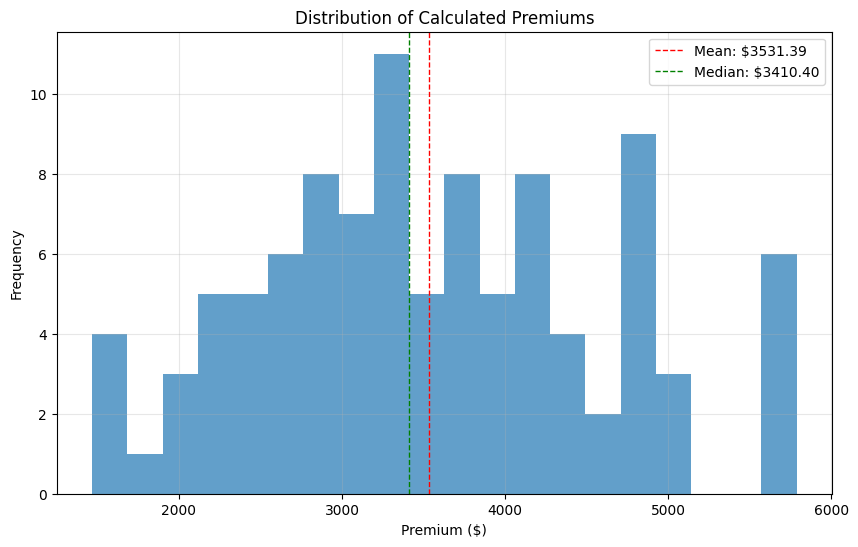

Premium Statistics:
Mean: $3531.39
Median: $3410.40
Min: $1467.45
Max: $5788.34
Standard Deviation: $1047.36


In [18]:
# Generate multiple policies
num_policies = 100
test_policies = [data_generator.generate_policy() for _ in range(num_policies)]

# Calculate premiums
results = [service.calculate_premium(policy) for policy in test_policies]
test_premiums = [result[0] for result in results]
test_factors = [result[1] for result in results]

# Plot premium distribution
plt.figure(figsize=(10, 6))
plt.hist(test_premiums, bins=20, alpha=0.7)
plt.axvline(np.mean(test_premiums), color='red', linestyle='dashed', linewidth=1, label=f'Mean: ${np.mean(test_premiums):.2f}')
plt.axvline(np.median(test_premiums), color='green', linestyle='dashed', linewidth=1, label=f'Median: ${np.median(test_premiums):.2f}')
plt.xlabel('Premium ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Calculated Premiums')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print premium statistics
print(f"Premium Statistics:")
print(f"Mean: ${np.mean(test_premiums):.2f}")
print(f"Median: ${np.median(test_premiums):.2f}")
print(f"Min: ${np.min(test_premiums):.2f}")
print(f"Max: ${np.max(test_premiums):.2f}")
print(f"Standard Deviation: ${np.std(test_premiums):.2f}")

Factor Statistics:


,driver_factor,vehicle_factor,history_factor,location_factor,credit_factor,insurance_factor,territory_factor
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.077950,0.156891,0.666054,0.099105,1.285000,1.165000,1.183822
std,2.258432,1.061668,2.476319,0.346962,0.254008,0.171373,0.199496
min,-8.383644,-5.147623,-11.460269,-1.419907,0.800000,0.800000,0.809203
25%,0.128808,0.111654,0.250000,-0.048225,1.000000,1.000000,1.022453
50%,0.250000,0.250000,0.250000,0.250000,1.500000,1.300000,1.199424
75%,0.250000,0.250000,0.717611,0.250000,1.500000,1.300000,1.348015
max,15.589366,7.379858,14.902776,2.119610,1.500000,1.300000,1.489463


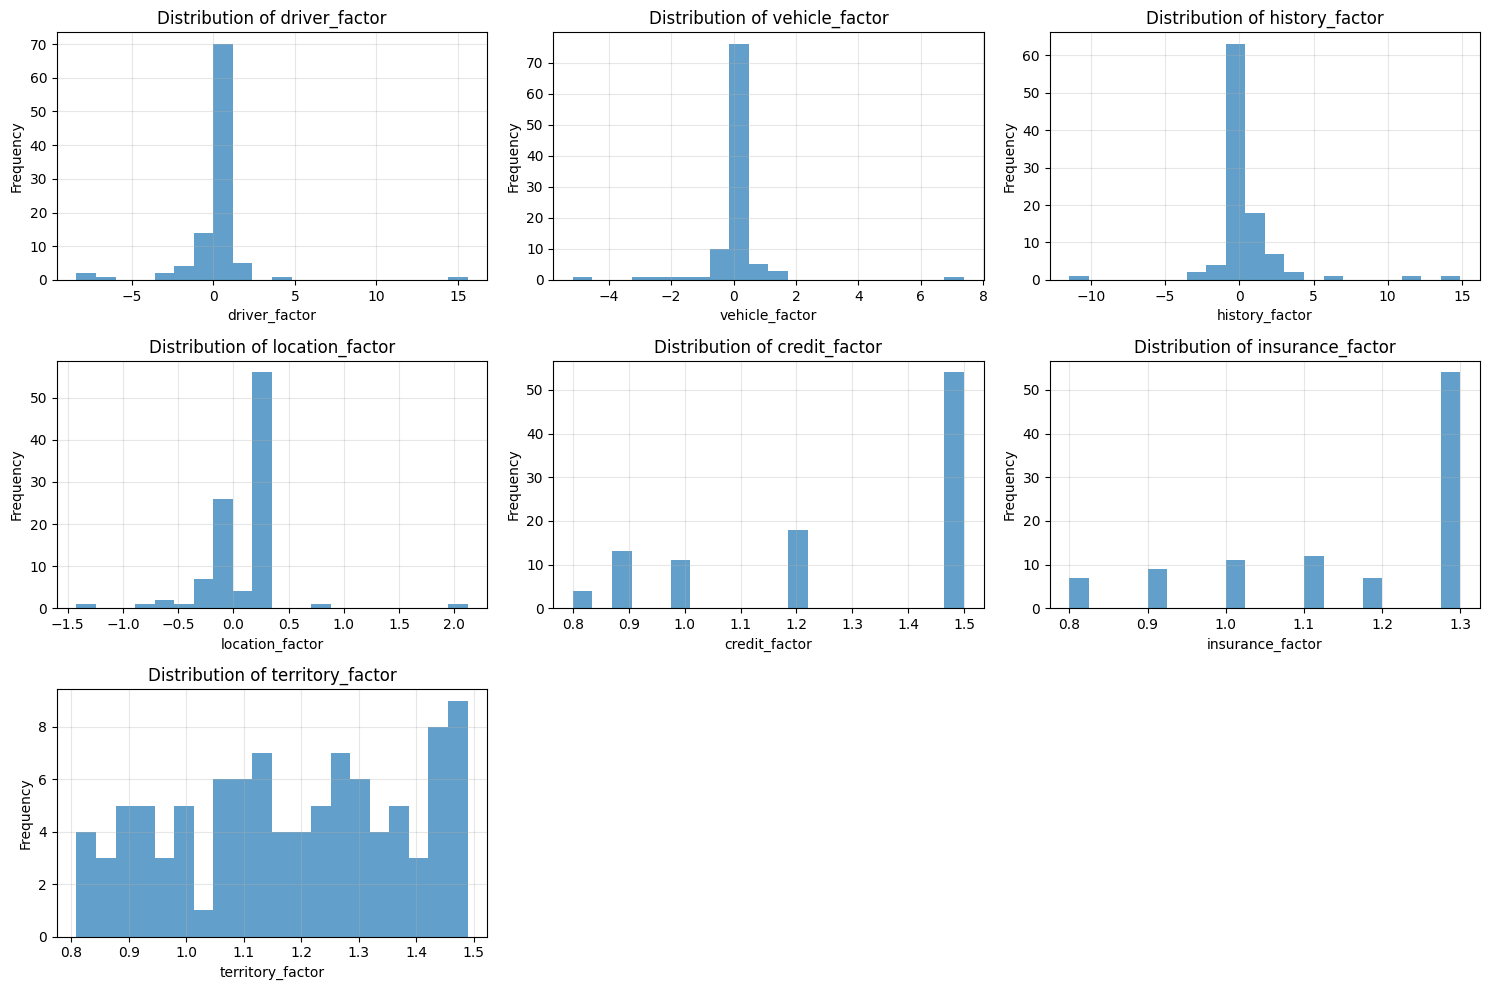

In [19]:
# Analyze factors
factor_names = list(test_factors[0].keys())
factor_values = {}

for factor in factor_names:
    factor_values[factor] = [factors.get(factor, 0) for factors in test_factors]

# Create DataFrame for factors
factor_df = pd.DataFrame(factor_values)

# Display factor statistics
print("Factor Statistics:")
display(factor_df.describe())

# Plot factor distributions
plt.figure(figsize=(15, 10))
for i, factor in enumerate(factor_names):
    plt.subplot(3, 3, i+1)
    plt.hist(factor_values[factor], bins=20, alpha=0.7)
    plt.xlabel(factor)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {factor}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Analysis

Let's analyze the correlation between different factors and the premium.

Correlation with Premium:


premium             1.000000
credit_factor       0.656131
territory_factor    0.529777
insurance_factor    0.502039
driver_factor       0.146749
vehicle_factor      0.139737
location_factor     0.101318
history_factor     -0.207942
Name: premium, dtype: float64

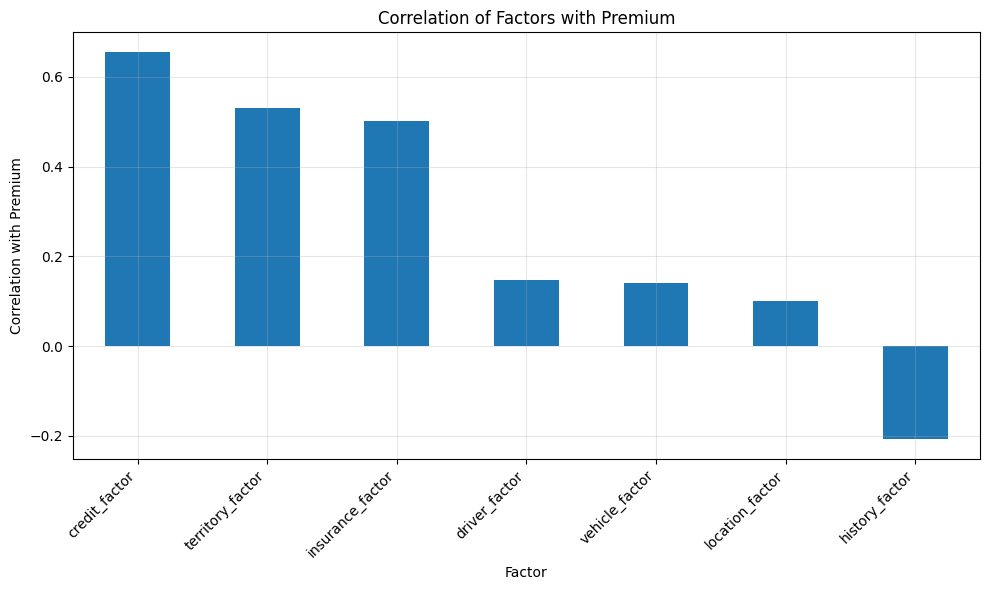

In [20]:
# Add premium to factor DataFrame
factor_df['premium'] = test_premiums

# Calculate correlation with premium
correlation = factor_df.corr()['premium'].sort_values(ascending=False)

print("Correlation with Premium:")
display(correlation)

# Plot correlation
plt.figure(figsize=(10, 6))
correlation.drop('premium').plot(kind='bar')
plt.xlabel('Factor')
plt.ylabel('Correlation with Premium')
plt.title('Correlation of Factors with Premium')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Model Serialization

Let's save and load the model to demonstrate serialization.

In [21]:
# Create a temporary directory
import tempfile
temp_dir = tempfile.TemporaryDirectory()

# Save the model
model_path = model.save(temp_dir.name)
print(f"Model saved to {model_path}")

# Load the model
loaded_model = InsurancePricingModel(model_path=model_path)
print(f"Model loaded from {model_path}")

# Compare predictions
original_pred = model.predict([new_policy])[0]
loaded_pred = loaded_model.predict([new_policy])[0]

print(f"Original prediction: {original_pred:.4f}")
print(f"Loaded prediction: {loaded_pred:.4f}")
print(f"Difference: {abs(original_pred - loaded_pred):.4f}")

# Clean up
temp_dir.cleanup()

Model saved to /tmp/tmpz1ewfbph/decision_tree_20250413233121.joblib
Model loaded from /tmp/tmpz1ewfbph/decision_tree_20250413233121.joblib
Original prediction: 1798.0548
Loaded prediction: 1798.0548
Difference: 0.0000


## Conclusion

In this notebook, we explored the insurance pricing model, including data generation, feature engineering, model training, and evaluation. We found that the model can accurately predict insurance premiums based on various factors such as driver demographics, vehicle characteristics, driving history, and location.